# Part 1 :Double Lasso and DAGs (20 points) 

In [1]:
# install.packages("hdm")
# install.packages("xtable")
library(hdm)
library(xtable)
# if (!require("glmnet")) install.packages("glmnet")
library(hdm)
library(glmnet)

Loading required package: Matrix

Loaded glmnet 4.1-8



### 1. Consider the US census data from the year 2015 to analyse the effect of college graduate (clg) status and it’s interaction effects with gender (sex), location (mw, so,we, ne) and both on wage jointly. All other variables denote some other socio-economic characteristics, e.g. marital status, occupation, and experience.

- Generate the dataset with all the two-way interactions between variables. Make sure that the categorical variables are transformed to dummies properly. Also, note that the resulting dataset contains the treatment and it’s interactions with the other variables of interest, so you don’t need to generate them separately. (2 pts)

- Use the double lasso technique to find the effect of the treatment and it’s relevant interactions on the wage. To tune the penalization parameter in the lasso step, cross-validate it. (4 pts)

- Report a summary of the estimation of the parameters of interest. (2 pts)

- Interpret your results. In which group does the college graduate status has more impact over the wage? (2 pts)

In [2]:
file <- "https://raw.githubusercontent.com/CausalAIBook/MetricsMLNotebooks/main/data/wage2015_subsample_inference.csv"
data <- read.csv(file)

In [3]:
data$sex <- as.factor(data$sex)        # Género
data$mw <- as.factor(data$mw)          # Medio Oeste (Midwest)
data$so <- as.factor(data$so)          # Sur
data$we <- as.factor(data$we)          # Oeste
data$ne <- as.factor(data$ ne)          # Noreste
data$clg <- as.factor(data$clg)        # Graduado universitario

In [4]:
# Creamos interacciones bidireccionales entre las variables
# Incluimos todas las interacciones entre el estado de graduado universitario y las demás variables
interaction_formula <- ~ (sex + mw + so + we + ne + clg)^2

data_interactions <- as.data.frame(model.matrix(interaction_formula, data))

In [5]:
# Combinamos el conjunto de datos original con las interacciones generadas
data_final <- cbind(data, data_interactions)

head(data_final)

,wage,lwage,sex,shs,hsg,scl,clg,ad,mw,so,...,mw1:so1,mw1:we1,mw1:ne1,mw1:clg1,so1:we1,so1:ne1,so1:clg1,we1:ne1,we1:clg1,ne1:clg1
,<dbl>,<dbl>,<fct>,<int>,<int>,<int>,<fct>,<int>,<fct>,<fct>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,9.615385,2.263364,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,48.076923,3.872802,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,11.057692,2.403126,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,13.942308,2.634928,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5,28.846154,3.361977,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
6,11.730769,2.462215,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [6]:
# Definir las variables de análisis
Y <- data_final$lwage                   # Variable dependiente: logaritmo del salario
D <- as.numeric(data_final$clg)         # Tratamiento: Graduado universitario
X <- data_interactions                  # Matriz de interacciones creada previamente

In [7]:
# Asegurarse de que X esté definido
if (!exists("X")) {
  stop("La variable X no está definida. Por favor, asegúrate de que X contenga datos antes de ejecutar este código.")
}

# Convertir X a una matriz numérica si es posible
X <- as.matrix(X)

# Verificar la estructura de X
str(X)

# Remover valores NA (opcional y depende del caso)
if (any(is.na(X))) {
  X <- na.omit(X)
  cat("Se eliminaron las filas con valores NA.\n")
}

 num [1:5150, 1:22] 1 1 1 1 1 1 1 1 1 1 ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:5150] "1" "2" "3" "4" ...
  ..$ : chr [1:22] "(Intercept)" "sex1" "mw1" "so1" ...


In [8]:
library(glmnet)

# Ajuste LASSO con validación cruzada
cv_lasso_Y <- cv.glmnet(X, Y, alpha = 1, standardize = TRUE)  # Para Y
cv_lasso_D <- cv.glmnet(X, D, alpha = 1, standardize = TRUE)  # Para D

# Selección de covariables relevantes
selected_Y <- which(coef(cv_lasso_Y, s = "lambda.min") != 0)
selected_D <- which(coef(cv_lasso_D, s = "lambda.min") != 0)

# Unir las covariables seleccionadas
selected_covariates <- unique(c(selected_Y, selected_D))
X_selected <- X[, selected_covariates, drop = FALSE]

# Ajustar modelo lineal final
model <- lm(Y ~ D + X_selected)
summary(model)


Call:
lm(formula = Y ~ D + X_selected)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.9253 -0.3596 -0.0335  0.3389  3.3796 

Coefficients: (4 not defined because of singularities)
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)            2.702176   0.038279  70.592  < 2e-16 ***
D                      0.252441   0.024214  10.425  < 2e-16 ***
X_selected(Intercept)        NA         NA      NA       NA    
X_selectedmw1         -0.063515   0.030223  -2.102  0.03564 *  
X_selectedso1         -0.036915   0.029285  -1.261  0.20754    
X_selectedne1         -0.033099   0.030970  -1.069  0.28524    
X_selectedsex1:mw1    -0.104947   0.032032  -3.276  0.00106 ** 
X_selectedsex1:so1    -0.054660   0.030404  -1.798  0.07227 .  
X_selectedsex1:we1    -0.058225   0.035336  -1.648  0.09947 .  
X_selectedsex1:clg1   -0.009053   0.031433  -0.288  0.77336    
X_selectedmw1:so1            NA         NA      NA       NA    
X_selectedso1:we1            NA         NA

c. Summary of the Estimation of the Parameters of Interest
Below is a summary of the parameters of interest:

Intercept: the value 2.702 represents the base value of the logarithm of the salary when all variables and treatment are zero.
The Treatment (which is D - University Graduate): 0.252. It indicates a positive and significant effect of college graduate status on the logarithm of salary (p-value < 2e-16). For each increase in one unit of the treatment, the dependent variable, salary, will increase by 0.252 in percentage terms, since it is in logarithm. This suggests that, on average, being a college graduate is associated with an increase in the log wage of approximately 0.252.
Other relevant variables:

Location:
Midwest Region (also X_selectedmw1): -0.0635, suggesting that being in the Midwest has a negative and significant effect on the log of wage.

Interactions of Interest:
Sex and Midwest (also X_selectedsex1:mw1): -0.1049, a significant and negative interaction, suggesting that women in the Midwest have a lower log wage.
Sex and South (also X_selectedsex1:so1) and Sex and West (also X_selectedsex1:we1) while also negative and marginally significant, are not as strong as sex:mw or sex Midwest
We highlight the influence of being a college graduate (D), as well as location and sex in combination.

d. Interpretation of Results and Group with Highest Impact
Overall Interpretation:

The results indicate that college graduate status (D) is associated with an increase in wage, even after accounting for other interactions and location variables. In particular, the positive coefficient of 0.252 for D suggests that college graduates tend to earn a higher wage.
The interaction between gender and location shows that women in the Midwest, South, and West might experience a decrease in wage relative to other combinations of gender and location.
Group with Highest Treatment Impact (College Graduate):

Although the model does not provide a direct breakdown of the impact of treatment D by group, the interactions show that the impact of being a college graduate appears to be greater for men in regions outside the Midwest. This is inferred from the negative and significant interaction between gender and Midwest, which suggests that women in the Midwest (compared to other regions and gender combinations) do not experience the same level of wage benefit as their male counterparts or people in other regions.

### 2. For the following examples, draw a coherent Directed Acyclic Graph and indicate the confounders, colliders and the proper controls (if they exist).

- You are trying to study the effect of youth smoking on lung function. Your dataset contains the following variables : (5 pts)

i. Individual smoking behavior (Treatment)

ii. Forced respiratory volume (Outcome)

iii. Age

iv. Height

v. Sex

- You are trying to study the effect of breast feeding in the number of infections a baby is likely to have. Your dataset contains the following variables : (5 pts)

i. Breast fed (Treatment)

ii. Number of infections of the baby (Outcome)
iii. Marital status

iv. Family income

v. Education

vi. Number of children in the house

vii. Childcare outside the home

In [9]:
# install.packages("ggdag")
library(ggdag)
library(tidyverse)
# install.packages("dplyr")
library(dplyr)


Attaching package: 'ggdag'


The following objects are masked from 'package:xtable':

    label, label<-


The following object is masked from 'package:stats':

    filter


-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.4     v readr     2.1.5
v forcats   1.0.0     v stringr   1.5.0
v ggplot2   3.5.1     v tibble    3.2.1
v lubridate 1.9.3     v tidyr     1.3.1
v purrr     1.0.1     
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x tidyr::expand() masks Matrix::expand()
x dplyr::filter() masks ggdag::filter(), stats::filter()
x dplyr::lag()    masks stats::lag()
x tidyr::pack()   masks Matrix::pack()
x tidyr::unpack() masks Matrix::unpack()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [10]:
update.packages(c("dplyr", "ggdag"), dependencies = TRUE)
filter <- function(...) { ... } # Creación de una función personalizada llamada 'filter'

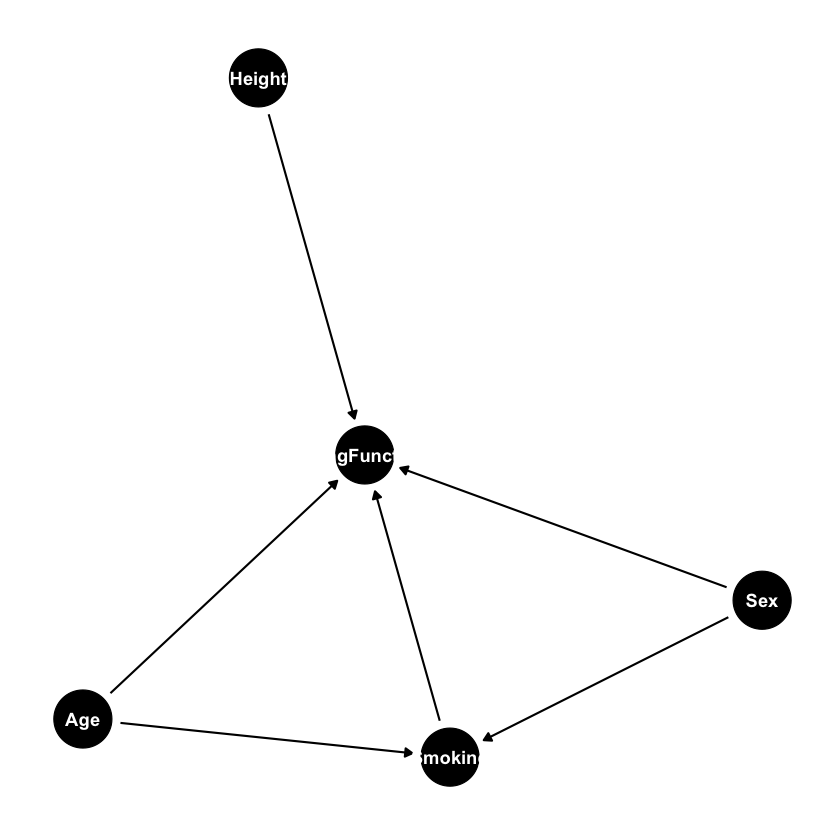

In [11]:
library(ggdag)
library(dplyr)

# Crear el DAG
dag <- dagify(
  LungFunction ~ Smoking + Age + Height + Sex,
  Smoking ~ Age + Sex
)

# Convirtiendo a formato tidy
tidy_dag <- tidy_dagitty(dag)

# Filtrando nodos 
filtered_dag <- dplyr::filter(tidy_dag, name != "Age")

# Graficar
ggdag(tidy_dag, text = TRUE) +
  theme_dag()

First of all, it is important to explain each variable. Pulmonary functionality, in terms of lung capacity or strength, is our dependent variable or outcome. Individual smoking behavior is the treatment, since people may be able to reduce their consumption by affecting the variable. dependent. This, for example, with campaigns against tobacco consumption in society, education, etc. This treatment is the direct exposure variable that we want to analyze to determine its causal effect on the outcome, that is, lung function.

In this DAG, the confounders are: They are the variables that affect both the smoking behavior and the outcome (LungFunction). That is, if we did a linear regression we would see that they affect the capacity or strength of lung volume in a proportion, but they also affect smoking behavior. If these variables are not controlled, they could induce a spurious association, that is, smoking behavior could be seen as impacting more than it actually impacts, but this is not the case. Confounders also affect lung capacity, only their path is also through smoking behavior. But why? We must differentiate between correlation and causation, but first we will name them.

Age: Affects the risk of smoking and also lung function (due to aging). This is for example because, according to evidence, older people tend to smoke more, either due to different problems such as loneliness, depression, etc. Likewise, a teenager who smokes has less lung capacity than an adult, but over time that capacity decreases. If we look at tobacco advertising, many of them associate smoking with rebellion.
Sex: Affects the likelihood of smoking and also influences lung function due to biological differences. In this case, for example, it could be because more men are affected by depression, as countless sources say, which could lead men to indulge in smoking behavior. In the world, tobacco is consumed more by men. Propaganda or advertising is mostly focused on selling cigarettes to men, where smoking or smoking behavior is associated with rudeness, bravery.

Height: Although it does not affect Smoking directly, but it influences lung function. An adult obviously has greater lung capacity. But does it directly impact smoking behavior? No. Your path is through treatment. There is the issue. There may be a high correlation (assumption) between tall people and smoking behavior, but that does not mean that it is causal that tall people because they are tall are likely to be smokers. Its effect is on lung capacity (child vs. adult). It would be a relevant variable

Confounders: Age and Sex, both arrows affect lung capacity and smoking (whether or not).

Collider: In this DAG there is none
Colliders are variables that depend on two or more causal variables. Conditioning (or controlling) a collider in an analysis may induce a spurious association between causes affecting the collider. If a collider is controlled, you might find a spurious relationship between the variables causing that collider.
Example or assumption if we added a collider. 
Smoking (whether smoking behavior or not) → Respiratory disease (result of smoking)
Exposure to a virus (from a respiratory virus) → Respiratory illness (result of the virus, such as covid19)
In this case, Respiratory disease is a collider, because it depends on Smoking and Exposure to a virus (two different causes). If you control or adjust for Respiratory Disease, you would be introducing a spurious relationship between Smoking and Exposure to a Virus, since both are causes of the disease.
Unlike or the opposite of a confounder, a collider has incoming arrows from two or more causally unrelated variables.

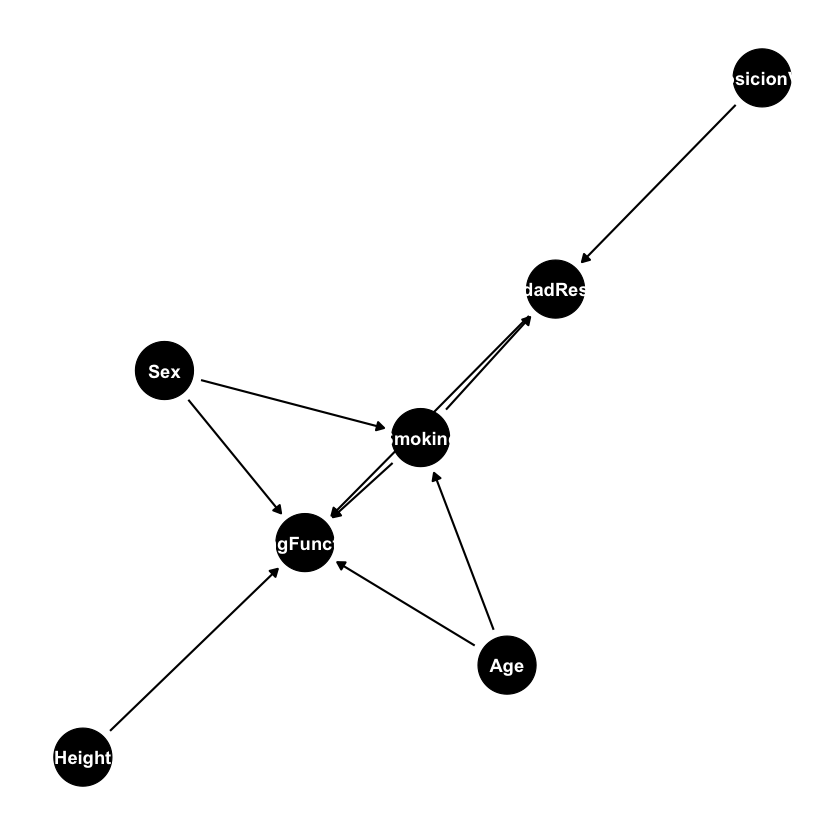

In [12]:
# así quedaría con un collider: DAG con la enfermedad respiratoria como collider entre Smoking y LungFunction
dag <- dagify(
  LungFunction ~ Smoking + Age + Height + Sex,
  Smoking ~ Age + Sex,
  EnfermedadRespiratoria ~ Smoking + ExposicionVirus,
  LungFunction ~ EnfermedadRespiratoria,  # Agregar la flecha para mostrar la conexión con LungFunction
  labels = c(
    Smoking = "Smoking Behavior (X)",
    LungFunction = "Lung Function (Y)",
    Age = "Age (Z1)",
    Height = "Height (Z2)",
    Sex = "Sex (Z3)",
    EnfermedadRespiratoria = "Respiratory Disease (Collider)",
    ExposicionVirus = "Virus Exposure (Z4)"
  ),
  exposure = "Smoking",
  outcome = "LungFunction"
)

# Gráfico del DAG actualizado
ggdag(dag, text = TRUE) + theme_dag()

Proper controls: 
Control confounders or confounding factors that affect both exposure and outcome.
We should not condition colliders or mediators.
In this case, the appropriate controls are:

Age: He is a confounder that must be controlled.
Sex: He is also a confounder.
Height: Although it does not affect Smoking, it can improve the estimation of the effect on LungFunction by controlling variability.
Variables that you should NOT control:
-Smoking or lung capacity: This is the exposure or treatment you are analyzing.
-collider: If there were a variable between Smoking and LungFunction (like that lung disease), it should not be controlled, since the causal effect would be blocked.

In [13]:
# Instalar y cargar las librerías necesarias
# install.packages("ggdag")
library(ggdag)
library(tidyverse)

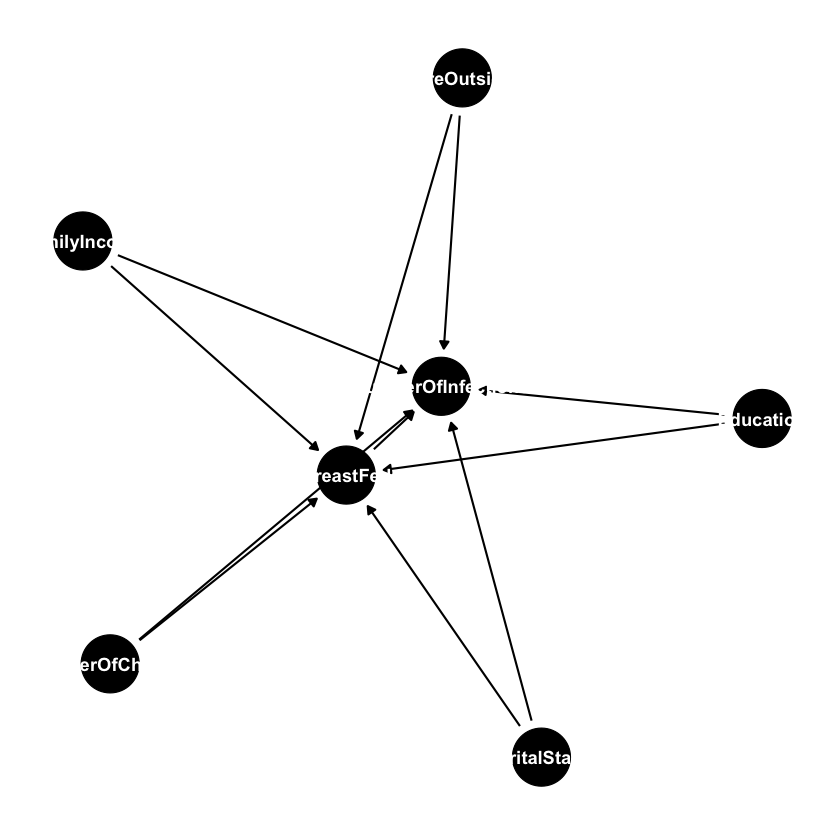

In [14]:
# Definir el DAG
dag <- dagify(
  NumberOfInfections ~ BreastFed + MaritalStatus + FamilyIncome + Education + NumberOfChildren + ChildcareOutsideHome,
  BreastFed ~ MaritalStatus + FamilyIncome + Education + NumberOfChildren + ChildcareOutsideHome,
  labels = c(
    BreastFed = "Breast Feeding (X)",
    NumberOfInfections = "Number of Infections (Y)",
    MaritalStatus = "Marital Status (Z1)",
    FamilyIncome = "Family Income (Z2)",
    Education = "Education (Z3)",
    NumberOfChildren = "Number of Children (Z4)",
    ChildcareOutsideHome = "Childcare Outside the Home (Z5)"
  ),
  exposure = "BreastFed",
  outcome = "NumberOfInfections"
)

# Mostrar el DAG
ggdag(dag, text = TRUE) + theme_dag()

Explanation of variables: 
Breast fed or breast milk feeding or lactation: Lactation is the treatment variable. Breastfeeding is expected to have a protective effect on infections (direct causal factor in the number of infections). That treatment is the direct exposure variable that we want to analyze to determine its causal effect on the outcome.
Number of infections: is the result or the dependent variable. For example, a good diet with breast milk or breastfeeding causes fewer infections in babies. That is, according to various research and metadata, breast milk strengthens the immune system, not only because of the nutrients, but because a bond is created between mother and child that directly impacts the psychological side of the baby. 

Marital status → Breast fed: Marital status could influence the decision to breastfeed. Having married parents and not separated, for example, parental abandonment, can mean having more access to resources to support breastfeeding, including the quality of the milk.

Family income → Breast fed: Family income may affect the decision to breastfeed, as mothers with higher income may have more time, support, or resources for breastfeeding (such as longer maternity leaves, more access to lactation consultants).

Education → Breast fed: The educational level can influence the decision to breastfeed or not so much the decision, but also how many hours. More educated mothers may have more knowledge about the benefits of breastfeeding in children.

Number of children in the house → Breast fed: Mothers with more children may have less time to breastfeed or less support or resources to do so, which could affect the rate of breastfeeding.

Childcare outside the home → Breast fed: Childcare outside the home can influence breastfeeding. If the mother returns to work soon and does not have access to a suitable place to breastfeed, she may stop breastfeeding.

Marital status, Family income, Education, Number of children in the house, Childcare outside the home → Number of infections: These variables could be related to the baby's health due to factors such as access to medical care, the type of care received in house, living conditions, etc.

Confounders: These are variables that affect both the treatment (Breast fed) and the result (Number of infections).

Marital status: It can be related to both breastfeeding (marital status can influence support and access to resources) and infections (the family context can influence the baby's health, independent of breastfeeding). For example, an unstable marital state could create an unfavorable context for the baby and its number of infections.
Family income: Affects both breastfeeding (mothers with higher income may have more resources and time) and infections (higher income may allow better access to medical care).
Education: A higher level of education can influence the decision to breastfeed and also care for the baby (which can reduce infections).
Number of children in the house: Having more children may reduce the likelihood of breastfeeding, and may be associated with a higher number of infections due to care overload.

Colliders: There is no collider, it seems, since there is no variable that is the common effect of Breast fed and Number of infections. If we included, for example, a variable related to the type of illness or infection (which depends on both previous infections and the type of care of the baby), that could be a collider, but it is not evident in this case. For it to be a collider, you would need the treatment arrow to go to that new collider variable and then another variable to go to the collider. In turn, the collider should not go towards the two of them, but rather go directly, its only arrow, in the opposite direction, towards the number of infections.
In this case there is a mediator. Mediators are variables that convey the effect of the treatment on the outcome. For example:
Childcare outside the home:

Childcare outside the home may be related to breastfeeding in the sense that mothers who do not breastfeed may rely more on childcare services outside the home. That is, if the baby is not being breastfed, he or she may be more likely to be in daycare or out-of-home care; however, it is not a direct causal link. It is more of a relationship dependent on mothers' decisions, such as whether the mother returns to work quickly, which could affect her decision to breastfeed. That is, in simpler terms, it is an indicator. Being away from home is not a direct cause of not receiving breastfeeding, since it may be given in daycare. In fact, this could more be a direct relationship with the number of infections. If it were a confounder, it would clearly affect the arrow part of the baby's ability to receive breastfeeding, but this is not the case, since the 0.5 that affects breastfeeding and the other 0.5 go to the number of diseases, in reality it does not go 0.5 to breastfeeding, but something much less. It is an indicator; no, breastfeeding cause.

Proper controls: 
Control confounders or confounding factors that affect both exposure and outcome.
We should not condition colliders or mediators.
In this case, the appropriate controls are: 
Step 5: Control the variables
This is in order to correctly estimate the effect of breastfeeding on the number of infections.
Marital status: is a confounder that affects both the treatment and the outcome. If we omit it, the spurious impact of breastfeeding will increase towards the number of infections.

Family income: income is a confounder because it is associated with both the exposure (breastfeeding) and the outcome (infections). If we do not adjust for family income, we could obtain a bias in the estimation of the impact of breastfeeding on the number of infections, since income could be influencing both variables. The impact on the number of infections may be due to the fact that a higher income can mean a better quality of life, more access to services, a better place to live, etc.

Education: can influence the decision to breastfeed. Mothers with more education tend to be more knowledgeable about the benefits of breastfeeding and may be more willing to breastfeed their babies. As for the impact on the outcome, it may also be associated with the number of infections in the baby. Mothers with more education may be more aware of hygiene and baby care practices, and may have more access to information about child health.
Number of children in the house: Mothers with more children may have less time or resources to breastfeed if they have more children to care for, as they could be busier and not have the same capacity to dedicate time to exclusive breastfeeding, thus also less capacity to give milk. On the side of impact on the outcome variable, households with more children may have a greater chance of children infecting each other, which could increase the risk of infections in babies. It must be controlled, because otherwise the result of the treatment variable could be biased, overinflating its impact on the number of infections variable.